## Read dataset

In [1]:
import numpy as np
import os
from tensorflow.keras import layers
import keras
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt
import tensorflow as tf

import PIL
from PIL import ImageOps
from PIL import Image 
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm


In [2]:
input_dat = np.load(os.path.join('../data_fin/train_input_dat.npy'))
target_dat = np.load(os.path.join('../data_fin/train_target_dat.npy'))

In [3]:
train_input_dat=input_dat[1500:,:,:,:]
train_target_dat=target_dat[1500:,:,:,:]

val_input_dat=input_dat[:1500,:,:,:]
val_target_dat=target_dat[:1500,:,:,:]



## What classes are in the dataset

### Entire dataset

<BarContainer object of 9 artists>

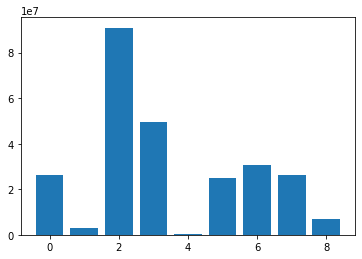

In [119]:
flat=np.argmax(target_dat, axis=-1).flatten()
unique, counts = np.unique(flat, return_counts=True)
plt.bar(unique, counts)

### Traing dataset

<BarContainer object of 9 artists>

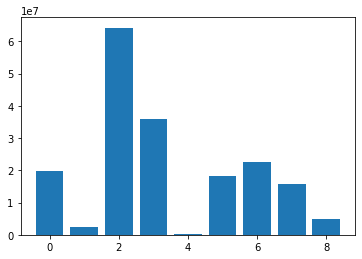

In [120]:
flat=np.argmax(train_target_dat, axis=-1).flatten()
unique, counts = np.unique(flat, return_counts=True)
plt.bar(unique, counts)

### Testing dataset

<BarContainer object of 9 artists>

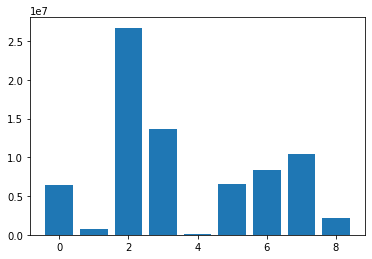

In [121]:
flat=np.argmax(val_target_dat, axis=-1).flatten()
unique, counts = np.unique(flat, return_counts=True)
plt.bar(unique, counts)

## Sample image and mask

(224, 224, 3)


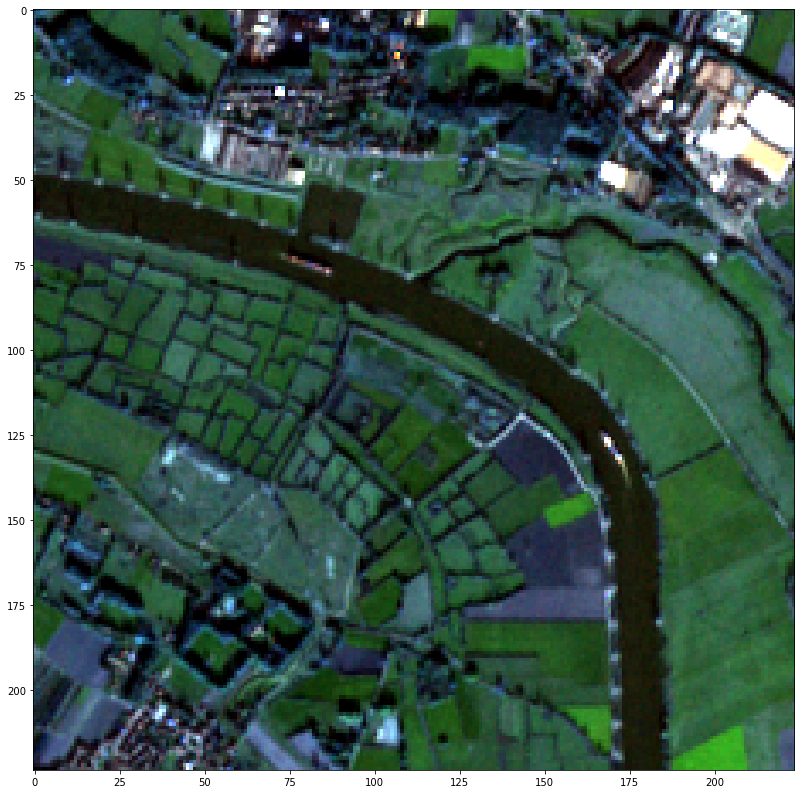

/home/bd/anaconda3/envs/tf-gpu4/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


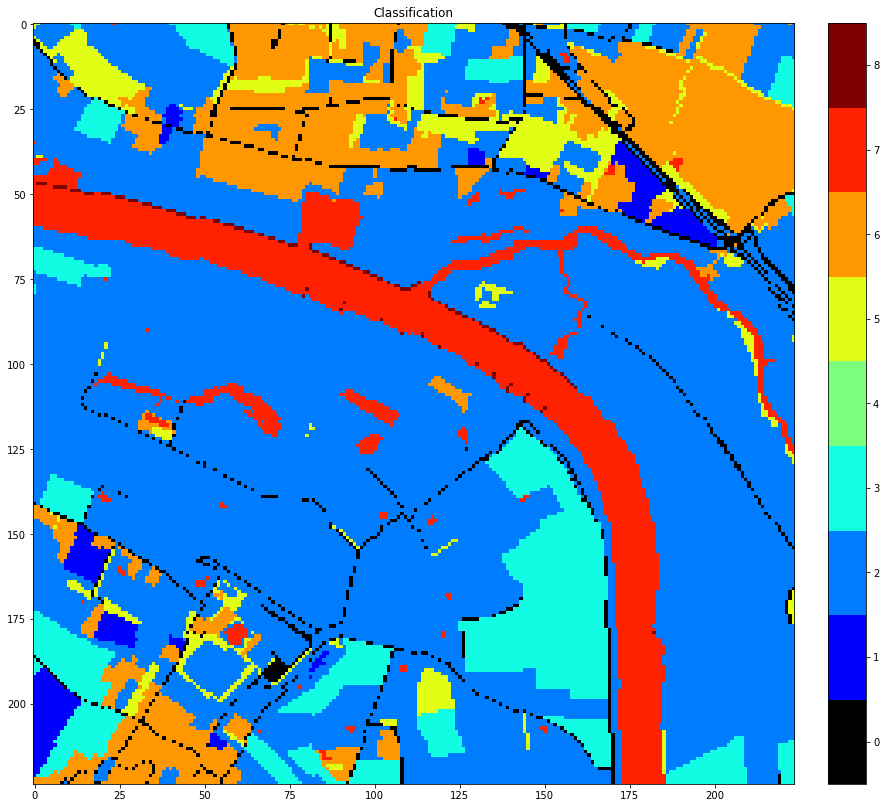

In [4]:

def Setcmap(D, inv=1):
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.0, .0, .0, 1.0)
    if inv:
        cmap = LinearSegmentedColormap.from_list('Custom_cmap', cmaplist, cmap.N)
    else:
        cmap = LinearSegmentedColormap.from_list('Custom_cmap', cmaplist[::-1], cmap.N)
    plt.register_cmap(name='Custom_cmap', cmap=cmap)
    bounds = np.linspace(0, D, D+1)
    norm = BoundaryNorm(bounds, cmap.N)
    return cmap, norm



def display_image(I):
    print(I.shape)
    tmp = np.zeros((I.shape[0], I.shape[1], 3), dtype=np.uint8)
    for q in range(3):
        a = copy.copy(I[:,:,q]) 
        D = a>0
        prc = np.percentile(a[D],[1,99])
        tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
    plt.imshow(tmp)
    f = plt.gcf()
    f.set_size_inches(15, 14)
    plt.show()
    
def display_target(I):
    cmap, norm = Setcmap(9)
    Class=np.argmax(I, axis=-1)
    im = plt.imshow(Class, cmap=cmap, norm=norm, vmin=0, vmax=9)
    plt.title('Classification')
    plt.set_cmap(cmap)
    cb = plt.colorbar(im, fraction=0.046, pad=0.04, ticks=range(9))
    cb.set_ticks(np.arange(9) + .5)
    cb.set_ticklabels(np.arange(9))
    plt.gcf().set_size_inches(15, 14)
    plt.show()
    
    
    
    
# Display results for validation image #10
i = 78


# Display input image
display_image(val_input_dat[i])

# Display ground-truth target mask
display_target(val_target_dat[i])
    

## Perpare U-Net Xception-style model

In [76]:

img_size = (224, 224)
num_classes = 9
batch_size = 32

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256,512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [512,256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
num_classes=9
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

https://keras.io/api/metrics/segmentation_metrics/#image-segmentation-metrics

## Train

In [77]:
#Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
  
#  

model.compile(
  optimizer='sgd',
  loss='mse',
  metrics=[tf.keras.metrics.CategoricalCrossentropy()]
)

model_name='unet-8Mv001.h5'

callbacks = [
    keras.callbacks.ModelCheckpoint('weights/'+model_name, save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 100
history=model.fit(train_input_dat, train_target_dat, epochs=epochs, 
                  validation_data=(val_input_dat,val_target_dat), callbacks=callbacks)

Epoch 1/100
115/115 [==============================] - 324s 3s/step - loss: 0.1238 - categorical_crossentropy: 4.8963 - val_loss: 0.1143 - val_categorical_crossentropy: 2.7471
Epoch 2/100
115/115 [==============================] - 41s 359ms/step - loss: 0.1085 - categorical_crossentropy: 4.0102 - val_loss: 0.1560 - val_categorical_crossentropy: 4.3824
Epoch 3/100
115/115 [==============================] - 40s 349ms/step - loss: 0.1028 - categorical_crossentropy: 3.7178 - val_loss: 0.1625 - val_categorical_crossentropy: 5.0471
Epoch 4/100
115/115 [==============================] - 40s 348ms/step - loss: 0.0993 - categorical_crossentropy: 3.4844 - val_loss: 0.1519 - val_categorical_crossentropy: 4.5959
Epoch 5/100
115/115 [==============================] - 41s 353ms/step - loss: 0.0967 - categorical_crossentropy: 3.2914 - val_loss: 0.1096 - val_categorical_crossentropy: 2.9447
Epoch 6/100
115/115 [==============================] - 40s 352ms/step - loss: 0.0945 - categorical_crossentropy:

Epoch 47/100
115/115 [==============================] - 40s 345ms/step - loss: 0.0681 - categorical_crossentropy: 1.5499 - val_loss: 0.0632 - val_categorical_crossentropy: 1.4813
Epoch 48/100
115/115 [==============================] - 40s 345ms/step - loss: 0.0680 - categorical_crossentropy: 1.5439 - val_loss: 0.0631 - val_categorical_crossentropy: 1.4754
Epoch 49/100
115/115 [==============================] - 40s 346ms/step - loss: 0.0678 - categorical_crossentropy: 1.5393 - val_loss: 0.0630 - val_categorical_crossentropy: 1.4693
Epoch 50/100
115/115 [==============================] - 39s 343ms/step - loss: 0.0679 - categorical_crossentropy: 1.5384 - val_loss: 0.0630 - val_categorical_crossentropy: 1.4789
Epoch 51/100
115/115 [==============================] - 40s 347ms/step - loss: 0.0677 - categorical_crossentropy: 1.5294 - val_loss: 0.0629 - val_categorical_crossentropy: 1.4650
Epoch 52/100
115/115 [==============================] - 40s 344ms/step - loss: 0.0676 - categorical_cross

Epoch 93/100
115/115 [==============================] - 40s 349ms/step - loss: 0.0644 - categorical_crossentropy: 1.4045 - val_loss: 0.0595 - val_categorical_crossentropy: 1.3196
Epoch 94/100
115/115 [==============================] - 40s 345ms/step - loss: 0.0644 - categorical_crossentropy: 1.4032 - val_loss: 0.0595 - val_categorical_crossentropy: 1.3291
Epoch 95/100
115/115 [==============================] - 40s 350ms/step - loss: 0.0644 - categorical_crossentropy: 1.4003 - val_loss: 0.0594 - val_categorical_crossentropy: 1.3224
Epoch 96/100
115/115 [==============================] - 40s 346ms/step - loss: 0.0644 - categorical_crossentropy: 1.3982 - val_loss: 0.0595 - val_categorical_crossentropy: 1.3111
Epoch 97/100
115/115 [==============================] - 41s 355ms/step - loss: 0.0641 - categorical_crossentropy: 1.3926 - val_loss: 0.0593 - val_categorical_crossentropy: 1.3185
Epoch 98/100
115/115 [==============================] - 40s 351ms/step - loss: 0.0641 - categorical_cross

In [79]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'weights/'+model_name
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Evaluate model

## Visualizing model performance
### Let's plot the model accuracy and loss for the training and the validating set. Note that no random seed is specified for this notebook. For your notebook, there might be slight variance.

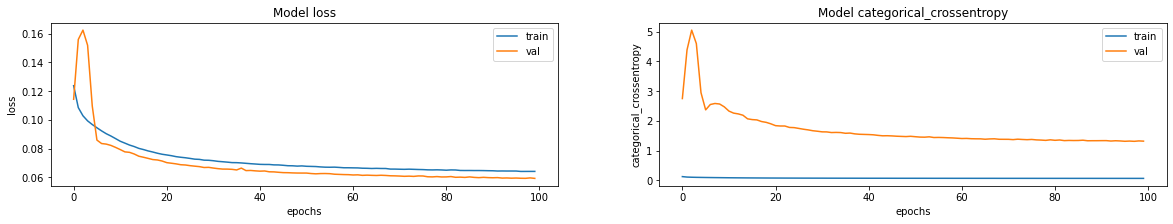

In [81]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'categorical_crossentropy']):
    ax[i].plot(hist_df['loss'])
    ax[i].plot(hist_df["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [82]:

model = get_model(img_size, num_classes)
model.summary()

fnmodel = 'weights/'+model_name
model.load_weights(filepath = fnmodel)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 112, 112, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 112, 112, 32) 128         conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 112, 112, 32) 0           batch_normalization_19[0][0]     
_______________________________________________________________________________________

OSError: Unable to open file (file signature not found)

## Confution matrix

https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

In [83]:
Y_pred = model.predict_generator((val_input_dat,val_target_dat), 1500 // batch_size+1)
y_pred= np.argmax(Y_pred, axis=3).flatten()
y= np.argmax(val_target_dat, axis=3).flatten()


Instructions for updating:
Please use Model.predict, which supports generators.


In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
target_names=['1','2','3','4','5','6','7','8','9']

cm = confusion_matrix(y, y_pred)


In [88]:
cm


array([[     503,     7032,   154799,    10824,  1818593,   127498,
            1134,  4181644,   140241],
       [      45,      831,    19400,     1500,   223549,    17056,
             149,   513156,    18869],
       [    1482,    21263,   659023,    28638,  6566602,   342737,
            2054, 18474029,   637421],
       [     679,    11350,   317828,    17953,  3510476,   178026,
             734,  9388971,   273347],
       [       9,      154,     2205,      430,    31392,     2985,
             127,    64450,     1478],
       [     483,     8077,   150854,    10926,  1863999,   168229,
            1663,  4183398,   134167],
       [     539,    12049,   199735,    17059,  2572017,   199329,
            1607,  5218157,   175006],
       [     473,    15264,   195593,    12541,  2454193,   169243,
            3553,  7440237,   143685],
       [     279,     3190,    52398,     4944,   624282,    45808,
             236,  1366764,    41357]])

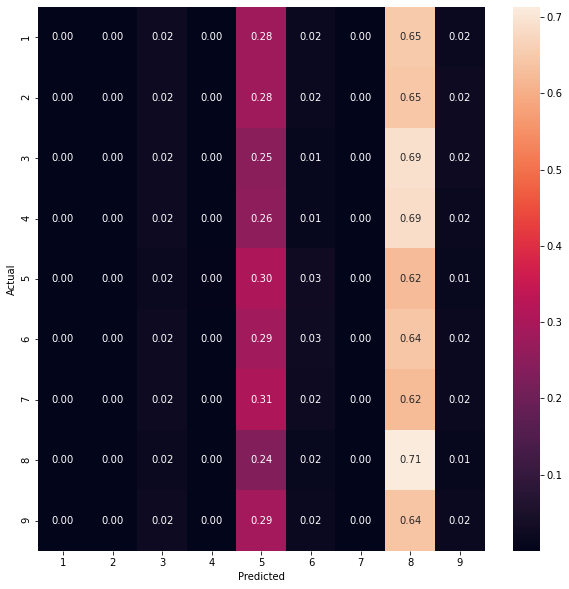

In [86]:
# Normalise
cmn = cm.astype('float') /cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Model Evaluate

## Visualize predictions

In [89]:
Y_pred.shape

(1500, 224, 224, 9)

In [90]:
val_target_dat[i].shape

(224, 224, 9)

(224, 224, 3)


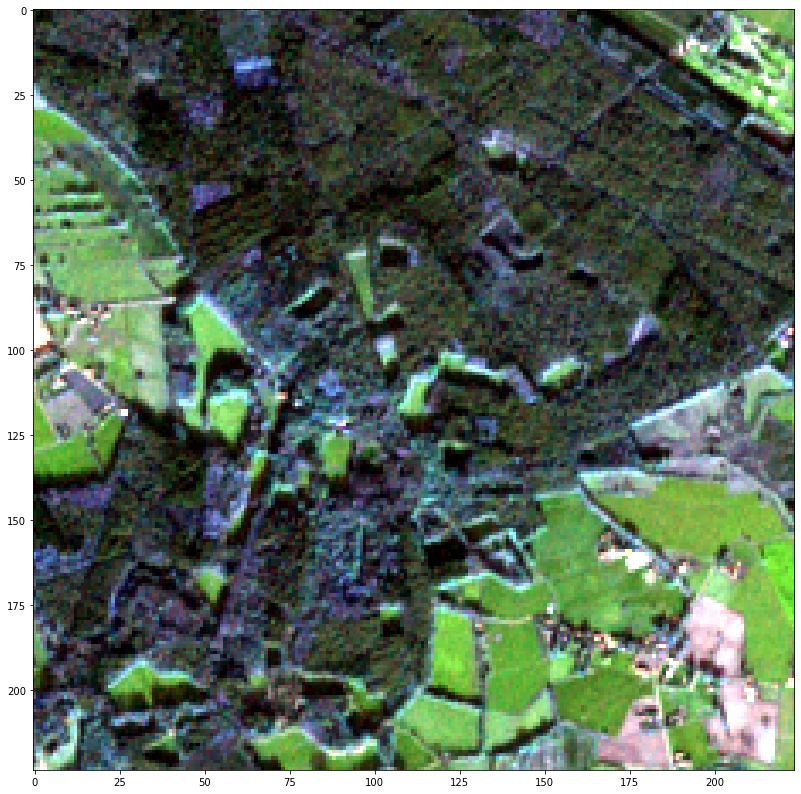

/home/bd/anaconda3/envs/tf-gpu4/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


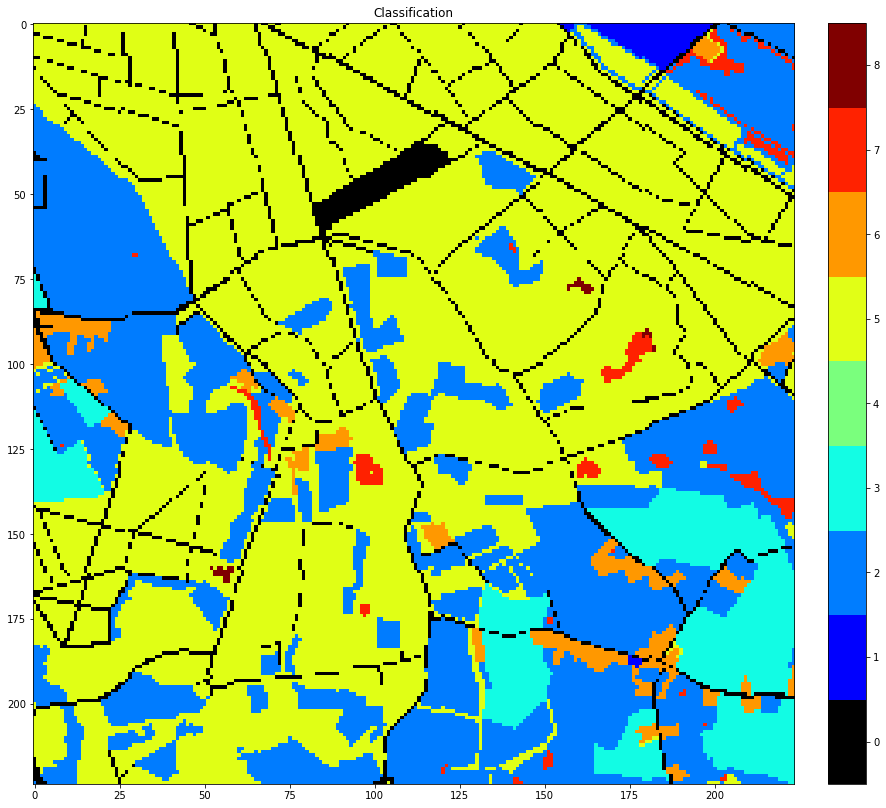

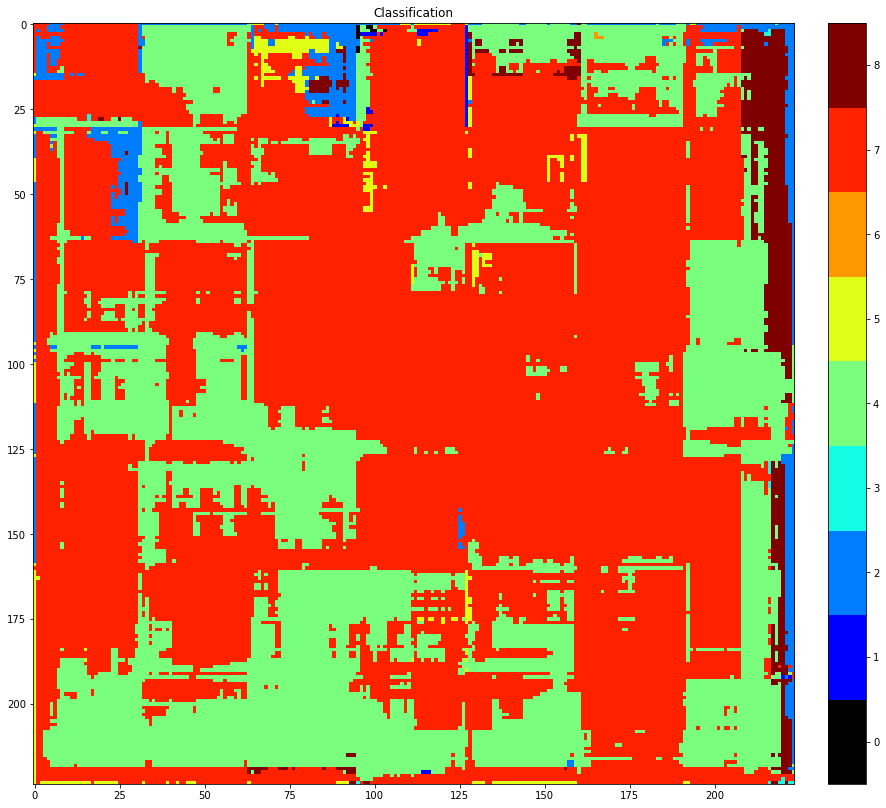

In [91]:
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
def Setcmap(D, inv=1):
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.0, .0, .0, 1.0)
    if inv:
        cmap = LinearSegmentedColormap.from_list('Custom_cmap', cmaplist, cmap.N)
    else:
        cmap = LinearSegmentedColormap.from_list('Custom_cmap', cmaplist[::-1], cmap.N)
    plt.register_cmap(name='Custom_cmap', cmap=cmap)
    bounds = np.linspace(0, D, D+1)
    norm = BoundaryNorm(bounds, cmap.N)
    return cmap, norm



def display_image(I):
    print(I.shape)
    tmp = np.zeros((I.shape[0], I.shape[1], 3), dtype=np.uint8)
    for q in range(3):
        a = copy.copy(I[:,:,q]) 
        D = a>0
        prc = np.percentile(a[D],[1,99])
        tmp[:,:,2-q] = np.digitize(a,np.linspace(prc[0],prc[1],255))*D
    plt.imshow(tmp)
    f = plt.gcf()
    f.set_size_inches(15, 14)
    plt.show()
    
def display_target(I):
    cmap, norm = Setcmap(9)
    Class=np.argmax(I, axis=-1)
    im = plt.imshow(Class, cmap=cmap, norm=norm, vmin=0, vmax=9)
    plt.title('Classification')
    plt.set_cmap(cmap)
    cb = plt.colorbar(im, fraction=0.046, pad=0.04, ticks=range(9))
    cb.set_ticks(np.arange(9) + .5)
    cb.set_ticklabels(np.arange(9))
    plt.gcf().set_size_inches(15, 14)
    plt.show()
    
# Display results for validation image #10
i = 12


# Display input image
display_image(val_input_dat[i])

# Display ground-truth target mask
display_target(val_target_dat[i])
# Display mask predicted by our model
#display_mask(i)  # Note that the model only sees inputs at 150x150.
display_target(Y_pred[i])


https://www.kaggle.com/meaninglesslives/unet-resnet34-in-keras